In [1]:
import gc, glob, os
from concurrent.futures import ProcessPoolExecutor

import h5py
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.stats import norm
from timm import create_model
from tqdm import tqdm

import torch
import torch.nn as nn
from thop import profile
import os
from pathlib import Path
import pandas as pd
##---------- Basic Layers ----------
def conv3x3(in_chn, out_chn, bias=True):
    layer = nn.Conv2d(in_chn, out_chn, kernel_size=3, stride=1, padding=1, bias=bias)
    return layer


def conv(in_channels, out_channels, kernel_size, bias=False, stride=1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size,
        padding=(kernel_size // 2),
        bias=bias,
        stride=stride,
    )


def bili_resize(factor):
    return nn.Upsample(scale_factor=factor, mode="bilinear", align_corners=False)


##---------- Basic Blocks ----------
class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, downsample):
        super(UNetConvBlock, self).__init__()
        self.downsample = downsample
        self.block = SK_RDB(in_channels=in_size, growth_rate=out_size, num_layers=3)
        if downsample:
            self.downsample = PS_down(out_size, out_size, downscale=2)

    def forward(self, x):
        out = self.block(x)
        if self.downsample:
            out_down = self.downsample(out)
            return out_down, out
        else:
            return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size):
        super(UNetUpBlock, self).__init__()
        # self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2, bias=True)
        self.up = PS_up(in_size, out_size, upscale=2)
        self.conv_block = UNetConvBlock(in_size, out_size, False)

    def forward(self, x, bridge):
        up = self.up(x)
        out = torch.cat([up, bridge], dim=1)
        out = self.conv_block(out)
        return out


##---------- Resizing Modules (Pixel(Un)Shuffle) ----------
class PS_down(nn.Module):
    def __init__(self, in_size, out_size, downscale):
        super(PS_down, self).__init__()
        self.UnPS = nn.PixelUnshuffle(downscale)
        self.conv1 = nn.Conv2d((downscale**2) * in_size, out_size, 1, 1, 0)

    def forward(self, x):
        x = self.UnPS(x)  # h/2, w/2, 4*c
        x = self.conv1(x)
        return x


class PS_up(nn.Module):
    def __init__(self, in_size, out_size, upscale):
        super(PS_up, self).__init__()

        self.PS = nn.PixelShuffle(upscale)
        self.conv1 = nn.Conv2d(in_size // (upscale**2), out_size, 1, 1, 0)

    def forward(self, x):
        x = self.PS(x)  # h/2, w/2, 4*c
        x = self.conv1(x)
        return x


##---------- Selective Kernel Feature Fusion (SKFF) ----------
class SKFF(nn.Module):
    def __init__(self, in_channels, height=3, reduction=8, bias=False):
        super(SKFF, self).__init__()

        self.height = height
        d = max(int(in_channels / reduction), 4)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv_du = nn.Sequential(
            nn.Conv2d(in_channels, d, 1, padding=0, bias=bias), nn.PReLU()
        )

        self.fcs = nn.ModuleList([])
        for i in range(self.height):
            self.fcs.append(
                nn.Conv2d(d, in_channels, kernel_size=1, stride=1, bias=bias)
            )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, inp_feats):
        batch_size, n_feats, H, W = inp_feats[1].shape

        inp_feats = torch.cat(inp_feats, dim=1)
        inp_feats = inp_feats.view(
            batch_size, self.height, n_feats, inp_feats.shape[2], inp_feats.shape[3]
        )

        feats_U = torch.sum(inp_feats, dim=1)
        feats_S = self.avg_pool(feats_U)
        feats_Z = self.conv_du(feats_S)

        attention_vectors = [fc(feats_Z) for fc in self.fcs]
        attention_vectors = torch.cat(attention_vectors, dim=1)
        attention_vectors = attention_vectors.view(
            batch_size, self.height, n_feats, 1, 1
        )

        attention_vectors = self.softmax(attention_vectors)
        feats_V = torch.sum(inp_feats * attention_vectors, dim=1)

        return feats_V


##---------- Dense Block ----------
class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels, I):
        super(DenseLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=3 // 2)
        self.relu = nn.ReLU(inplace=True)
        self.sk = SKFF(out_channels, height=2, reduction=8, bias=False)

    def forward(self, x):
        x1 = self.relu(self.conv(x))
        # output = torch.cat([x, x1], 1) # -> RDB
        output = self.sk((x, x1))
        return output


##---------- Selective Kernel Residual Dense Block (SK-RDB) ----------
class SK_RDB(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(SK_RDB, self).__init__()
        self.identity = nn.Conv2d(in_channels, growth_rate, 1, 1, 0)
        self.layers = nn.Sequential(
            *[DenseLayer(in_channels, in_channels, I=i) for i in range(num_layers)]
        )
        self.lff = nn.Conv2d(in_channels, growth_rate, kernel_size=1)

    def forward(self, x):
        res = self.identity(x)
        x = self.layers(x)
        x = self.lff(x)
        return res + x


##---------- testNet ----------
class SRMNet(nn.Module):
    def __init__(self, in_chn=3, wf=96, depth=4):
        super(SRMNet, self).__init__()
        self.depth = depth
        self.down_path = nn.ModuleList()
        self.bili_down = bili_resize(0.5)
        self.conv_01 = nn.Conv2d(in_chn, wf, 3, 1, 1)

        # encoder of UNet
        prev_channels = 0
        for i in range(depth):  # 0,1,2,3
            downsample = True if (i + 1) < depth else False
            self.down_path.append(
                UNetConvBlock(prev_channels + wf, (2**i) * wf, downsample)
            )
            prev_channels = (2**i) * wf

        # decoder of UNet
        self.up_path = nn.ModuleList()
        self.skip_conv = nn.ModuleList()
        self.conv_up = nn.ModuleList()
        self.bottom_conv = nn.Conv2d(prev_channels, wf, 3, 1, 1)
        self.bottom_up = bili_resize(2 ** (depth - 1))

        for i in reversed(range(depth - 1)):
            self.up_path.append(UNetUpBlock(prev_channels, (2**i) * wf))
            self.skip_conv.append(nn.Conv2d((2**i) * wf, (2**i) * wf, 3, 1, 1))
            self.conv_up.append(
                nn.Sequential(
                    *[nn.Conv2d((2**i) * wf, wf, 3, 1, 1), bili_resize(2**i)]
                )
            )
            prev_channels = (2**i) * wf

        self.final_ff = SKFF(in_channels=wf, height=depth)
        self.last = conv3x3(prev_channels, in_chn, bias=True)

    def forward(self, x):
        img = x
        scale_img = img

        ##### shallow conv #####
        x1 = self.conv_01(img)
        encs = []
        ######## UNet ########
        # Down-path (Encoder)
        for i, down in enumerate(self.down_path):
            if i == 0:
                x1, x1_up = down(x1)
                encs.append(x1_up)
            elif (i + 1) < self.depth:
                scale_img = self.bili_down(scale_img)
                left_bar = self.conv_01(scale_img)
                x1 = torch.cat([x1, left_bar], dim=1)
                x1, x1_up = down(x1)
                encs.append(x1_up)
            else:
                scale_img = self.bili_down(scale_img)
                left_bar = self.conv_01(scale_img)
                x1 = torch.cat([x1, left_bar], dim=1)
                x1 = down(x1)

        # Up-path (Decoder)
        ms_result = [self.bottom_up(self.bottom_conv(x1))]
        for i, up in enumerate(self.up_path):
            x1 = up(x1, self.skip_conv[i](encs[-i - 1]))
            ms_result.append(self.conv_up[i](x1))
        # Multi-scale selective feature fusion
        msff_result = self.final_ff(ms_result)

        ##### Reconstruct #####
        out_1 = self.last(msff_result) + img

        return out_1
    
    

def normalize(X):
    X = (X[..., None].view(X.real.dtype) ** 2).sum(-1)
    POS = int(X.size * 0.99903)
    EXP = norm.ppf((POS + 0.4) / (X.size + 0.215))
    scale = np.partition(X.flatten(), POS, -1)[POS]
    X /= scale / EXP.astype(scale.dtype) ** 2
    return X


def dataload(filepath):
    astime = np.full([2, 360, 5760], np.nan, dtype=np.float32)
    with h5py.File(filepath, "r") as f:
        fid, _ = os.path.splitext(os.path.split(filepath)[1])
        HT = (
            (np.asarray(f[fid]["H1"]["timestamps_GPS"]) / 1800).round().astype(np.int64)
        )
        LT = (
            (np.asarray(f[fid]["L1"]["timestamps_GPS"]) / 1800).round().astype(np.int64)
        )
        MIN = min(HT.min(), LT.min())
        HT -= MIN
        LT -= MIN
        H1 = normalize(np.asarray(f[fid]["H1"]["SFTs"], np.complex128))
        valid = HT < 5760
        astime[0][:, HT[valid]] = H1[:, valid]
        L1 = normalize(np.asarray(f[fid]["L1"]["SFTs"], np.complex128))
        valid = LT < 5760
        astime[1][:, LT[valid]] = L1[:, valid]
    gc.collect()
    return fid, astime, H1.mean(), L1.mean()


def normalize_custom(x, pmin=3, pmax=97, axis=None, clip=False, eps=1e-20, dtype=np.float32):
    """Percentile-based image normalization."""

    mi = np.percentile(x,pmin,axis=axis,keepdims=True)
    ma = np.percentile(x,pmax,axis=axis,keepdims=True)
    return normalize_mi_ma(x, mi, ma, clip=clip, eps=eps, dtype=dtype)


def normalize_mi_ma(x, mi, ma, clip=False, eps=1e-20, dtype=np.float32):
    if dtype is not None:
        x   = x.astype(dtype,copy=False)
        mi  = dtype(mi) if np.isscalar(mi) else mi.astype(dtype,copy=False)
        ma  = dtype(ma) if np.isscalar(ma) else ma.astype(dtype,copy=False)
        eps = dtype(eps)

    try:
        import numexpr
        x = numexpr.evaluate("(x - mi) / ( ma - mi + eps )")
    except ImportError:
        x =                   (x - mi) / ( ma - mi + eps )

    if clip:
        x = np.clip(x,0,1)

    return x



def preprocess(num, input, H1, L1):
    input = torch.from_numpy(input).to("cuda", non_blocking=True)
    rescale = torch.tensor([[H1, L1]]).to("cuda", non_blocking=True)
    tta = (
        torch.randn([num, *input.shape, 2], device=input.device, dtype=torch.float32)
        .square_()
        .sum(-1)
    )
    tta *= rescale[..., None, None] / 2
    valid = ~torch.isnan(input)
    tta[:, valid] = input[valid].float()
    return tta


class LargeKernel_debias(nn.Conv2d):
    def forward(self, input: torch.Tensor):
        finput = input.flatten(0, 1)[:, None]
        target = abs(self.weight)
        target = target / target.sum((-1, -2), True)
        joined_kernel = torch.cat([self.weight, target], 0)
        reals = target.new_zeros(
            [1, 1] + [s + p * 2 for p, s in zip(self.padding, input.shape[-2:])]
        )
        reals[
            [slice(None)] * 2
            + [slice(p, -p) if p != 0 else slice(None) for p in self.padding]
        ].fill_(1)
        output, power = torch.nn.functional.conv2d(
            finput, joined_kernel, padding=self.padding
        ).chunk(2, 1)
        ratio = torch.div(*torch.nn.functional.conv2d(reals, joined_kernel).chunk(2, 1))
        output = output.sub(power.mul(ratio))
        return output.unflatten(0, input.shape[:2]).flatten(1, 2)
    

def get_model(path):
    model = create_model(
        "tf_efficientnetv2_b0",
        in_chans=32,
        num_classes=2,
    )
    state_dict = torch.load(path)
    C, _, H, W = state_dict["conv_stem.2.weight"].shape
    print(C, _, H, W)
    model.conv_stem = nn.Sequential(
        nn.Identity(),
        nn.Identity(),
        LargeKernel_debias(1, C, [H, W], 1, [H // 2, W // 2], 1, 1, False),
        model.conv_stem,
    )
    model.load_state_dict(state_dict)
    return model.conv_stem[:3]

class LargeKernelModel(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.head = get_model('model_best.pth')
        self.enc = create_model(
                    CFG.model_name,
                    pretrained=True,
                    num_classes=CFG.num_classes,
                    in_chans=32,
                )
        
    def forward(self, x):
        x = self.head(x)
        return self.enc(x)


custom_model =  SRMNet(in_chn=2)
custom_model.load_state_dict(torch.load('../EXP_40/EXP_40_01_NV_TEST_V5/EXP_40_01_NV_TEST_V5_SRG_REAL_NOISE_TO_VOID_TEST_V5_DATA_V31_9.pth'))
custom_model.cuda();
custom_model.eval();

def custom_preprocess(x_in):
    b, c, h, w = x_in.shape
    x_in = x_in.reshape(b, c, 360, 288, 20).mean(-1)
    dev = x_in.device
    x_in = x_in.cpu().numpy()
    for i in range(x_in.shape[0]):
        x_in[i][0] = normalize_custom(x_in[i][0], clip = True)
        x_in[i][1] = normalize_custom(x_in[i][1], clip = True)
    return torch.tensor(x_in, device=dev)
from pdb import set_trace
@torch.no_grad()
def inference(model, path):
    file_path = glob.glob(os.path.join(path, "*.hdf5"))
    FID, RES = [], []
    with ProcessPoolExecutor(2) as pool:
        for fid, input, H1, L1 in tqdm(pool.map(dataload, sorted(file_path))):
            tta = preprocess(16, input, H1, L1)
            tta = custom_preprocess(tta)
            out = custom_model(tta)
            tta = torch.concat([tta, out], -1)
            FID += [fid]
            RES += [model(tta).sigmoid().mean(0)]
    return FID, torch.stack(RES, 0).cpu().float().numpy()

In [2]:
import matplotlib.pyplot as plt

In [3]:
class CFG:
    bs = 26
    nw = 8
    model_name = "convnext_large_in22k"
    lr = 1e-4
    wd = 1e-4
    epoch = 10
    warmup_pct = 0.1
    num_classes = 1
    dropout_rate = 0.3
    folder = "EXP_50_00_denoise_V5"
    mixup=False
    split_voldf = Path("../data/SPLITS/V_20")
    exp_name = f"{folder}_{model_name}_{split_voldf.stem}_{mixup}_POS"

In [4]:
model =  LargeKernelModel(CFG)
model.load_state_dict(torch.load('../EXP_50/EXP_50_00_denoise_V5_PSD/EXP_50_00_denoise_V5_PSD_convnext_large_in22k_V_20_False_POS_0_4.pth'))
model.eval();
model.cuda();

fid, infer = inference(model, "../data/test")


16 1 31 255


7975it [2:55:40,  1.32s/it]


In [5]:
result = pd.DataFrame.from_dict({"id": fid, "target": infer.reshape(-1)})

In [6]:
result.to_csv('TRUE_DEBIAS_DENOISE_V5_PSD.csv', index=False)

<AxesSubplot:ylabel='Frequency'>

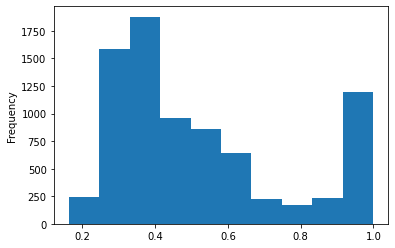

In [7]:
result['target'].plot.hist()